In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('loan.csv',low_memory=False)

In [3]:
df_null = pd.DataFrame({'Count': df.isnull().sum(), 'Percent': 100*df.isnull().sum()/len(df)})

##printing columns with null count more than 0
df_null[df_null['Count'] > 0] 

Count    Percent
emp_title                     51457   5.798762
annual_inc                        4   0.000451
desc                         761350  85.797613
title                           151   0.017016
delinq_2yrs                      29   0.003268
earliest_cr_line                 29   0.003268
inq_last_6mths                   29   0.003268
mths_since_last_delinq       454312  51.197065
mths_since_last_record       750326  84.555303
open_acc                         29   0.003268
pub_rec                          29   0.003268
revol_util                      502   0.056571
total_acc                        29   0.003268
last_pymnt_d                  17659   1.990018
next_pymnt_d                 252971  28.507661
last_credit_pull_d               53   0.005973
collections_12_mths_ex_med      145   0.016340
mths_since_last_major_derog  665676  75.015974
annual_inc_joint             886868  99.942415
dti_joint                    886870  99.942640
verification_status_joint    886868  99.942415
acc_now_delinq                   29   0.003268
tot_coll_amt                  70276   7.919502
tot_cur_bal                   70276   7.919502
open_acc_6m                  866007  97.591559
open_il_6m                   866007  97.591559
open_il_12m                  866007  97.591559
open_il_24m                  866007  97.591559
mths_since_rcnt_il           866569  97.654892
total_bal_il                 866007  97.591559
il_util                      868762  97.902024
open_rv_12m                  866007  97.591559
open_rv_24m                  866007  97.591559
max_bal_bc                   866007  97.591559
all_util                     866007  97.591559
total_rev_hi_lim              70276   7.919502
inq_fi                       866007  97.591559
total_cu_tl                  866007  97.591559
inq_last_12m                 866007  97.591559

In [4]:
df1 = df.dropna(axis=1, thresh=int(0.80*len(df)))

In [5]:
df1.head(5)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599     5000.0       5000.0           4975.0   36 months   
1  1077430    1314167     2500.0       2500.0           2500.0   60 months   
2  1077175    1313524     2400.0       2400.0           2400.0   36 months   
3  1076863    1277178    10000.0      10000.0          10000.0   36 months   
4  1075358    1311748     3000.0       3000.0           3000.0   60 months   

   int_rate  installment grade sub_grade       ...        last_pymnt_d  \
0     10.65       162.87     B        B2       ...            Jan-2015   
1     15.27        59.83     C        C4       ...            Apr-2013   
2     15.96        84.33     C        C5       ...            Jun-2014   
3     13.49       339.31     C        C1       ...            Jan-2015   
4     12.69        67.79     B        B5       ...            Jan-2016   

  last_pymnt_amnt last_credit_pull_d  collections_12_mths_ex_med policy_code  \
0          171.62           Jan-2016                         0.0         1.0   
1          119.66           Sep-2013                         0.0         1.0   
2          649.91           Jan-2016                         0.0         1.0   
3          357.48           Jan-2015                         0.0         1.0   
4           67.79           Jan-2016                         0.0         1.0   

  application_type acc_now_delinq tot_coll_amt tot_cur_bal total_rev_hi_lim  
0       INDIVIDUAL            0.0          NaN         NaN              NaN  
1       INDIVIDUAL            0.0          NaN         NaN              NaN  
2       INDIVIDUAL            0.0          NaN         NaN              NaN  
3       INDIVIDUAL            0.0          NaN         NaN              NaN  
4       INDIVIDUAL            0.0          NaN         NaN              NaN  

[5 rows x 52 columns]

In [6]:
df_LC = df1.filter(['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_length','home_ownership',
                    'annual_inc','verification_status','purpose','dti','delinq_2yrs','loan_status'])
df_LC.dtypes

loan_amnt              float64
term                    object
int_rate               float64
installment            float64
grade                   object
sub_grade               object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
purpose                 object
dti                    float64
delinq_2yrs            float64
loan_status             object
dtype: object

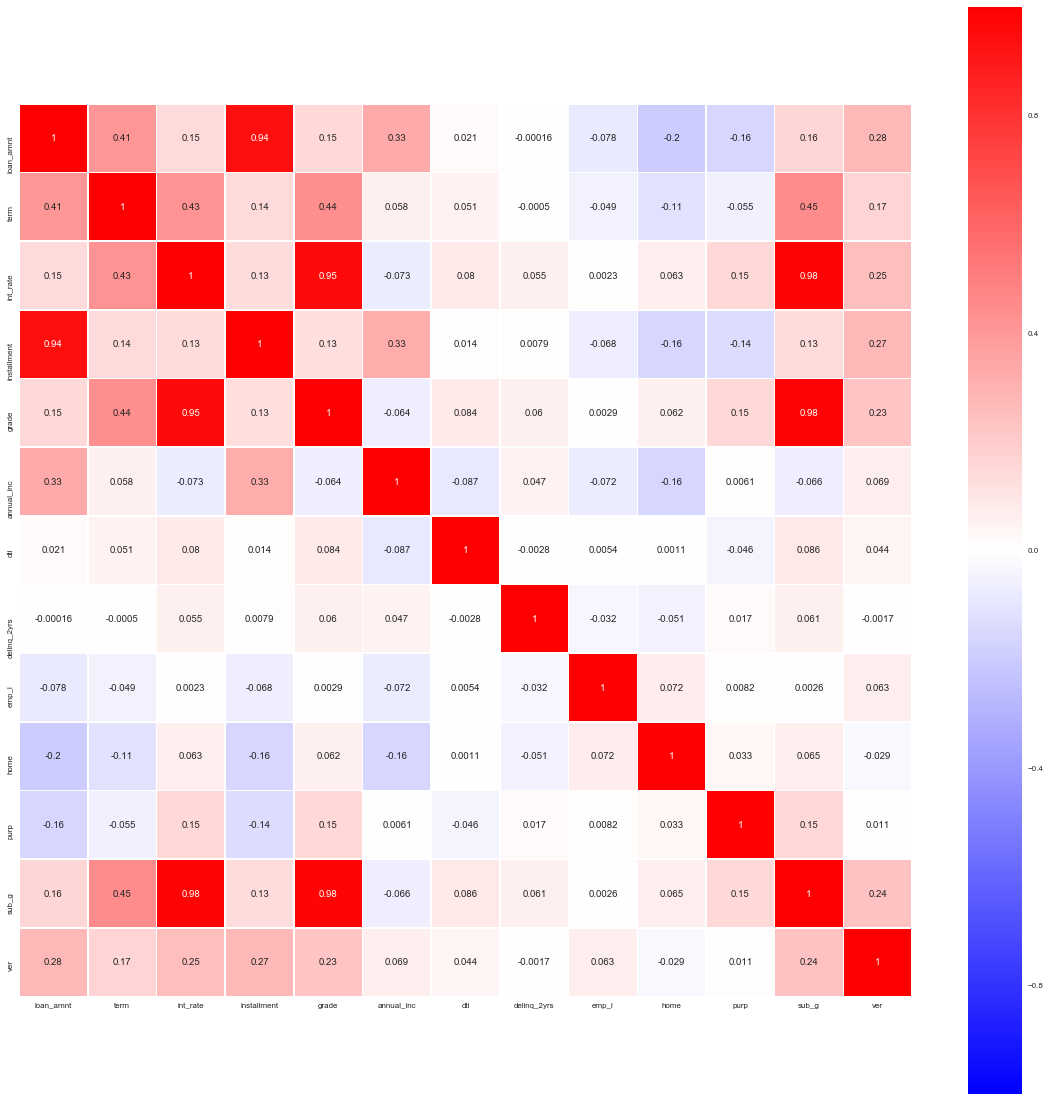

In [8]:
plt.figure(figsize=(20,20))
sns.set_context("paper", font_scale=1)
##finding the correllation matrix and changing the categorical data to category for the plot.
sns.heatmap(df_LC.assign(grade=df_LC.grade.astype('category').cat.codes,
                         sub_g=df_LC.sub_grade.astype('category').cat.codes,
                         term=df_LC.term.astype('category').cat.codes,
                        emp_l=df_LC.emp_length.astype('category').cat.codes,
                         ver =df_LC.verification_status.astype('category').cat.codes,
                        home=df_LC.home_ownership.astype('category').cat.codes,
                        purp=df_LC.purpose.astype('category').cat.codes).corr(), 
                         annot=True, cmap='bwr',vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.show()

In [9]:
df_LC.drop(['installment','grade','sub_grade','verification_status','term']
           , axis=1, inplace = True)


In [10]:
dflc_null = pd.DataFrame({'Count': df_LC.isnull().sum(), 'Percent': 100*df_LC.isnull().sum()/len(df_LC)})
dflc_null[dflc_null['Count'] > 0]

Count   Percent
annual_inc       4  0.000451
delinq_2yrs     29  0.003268

In [11]:
df_LC.dropna(axis=0)

loan_amnt  int_rate emp_length home_ownership  annual_inc  \
0          5000.0     10.65  10+ years           RENT    24000.00   
1          2500.0     15.27   < 1 year           RENT    30000.00   
2          2400.0     15.96  10+ years           RENT    12252.00   
3         10000.0     13.49  10+ years           RENT    49200.00   
4          3000.0     12.69     1 year           RENT    80000.00   
5          5000.0      7.90    3 years           RENT    36000.00   
6          7000.0     15.96    8 years           RENT    47004.00   
7          3000.0     18.64    9 years           RENT    48000.00   
8          5600.0     21.28    4 years            OWN    40000.00   
9          5375.0     12.69   < 1 year           RENT    15000.00   
10         6500.0     14.65    5 years            OWN    72000.00   
11        12000.0     12.69  10+ years            OWN    75000.00   
12         9000.0     13.49   < 1 year           RENT    30000.00   
13         3000.0      9.91    3 years           RENT    15000.00   
14        10000.0     10.65    3 years           RENT   100000.00   
15         1000.0     16.29   < 1 year           RENT    28000.00   
16        10000.0     15.27    4 years           RENT    42000.00   
17         3600.0      6.03  10+ years       MORTGAGE   110000.00   
18         6000.0     11.71     1 year       MORTGAGE    84000.00   
19         9200.0      6.03    6 years           RENT    77385.19   
20        20250.0     15.27    3 years           RENT    43370.00   
21        21000.0     12.42  10+ years           RENT   105000.00   
22        10000.0     11.71  10+ years            OWN    50000.00   
23        10000.0     11.71    5 years           RENT    50000.00   
24         6000.0     11.71     1 year           RENT    76000.00   
25        15000.0      9.91    2 years       MORTGAGE    92000.00   
26        15000.0     14.27    9 years           RENT    60000.00   
27         5000.0     16.77    2 years           RENT    50004.00   
28         4000.0     11.71  10+ years       MORTGAGE   106000.00   
29         8500.0     11.71   < 1 year           RENT    25000.00   
...           ...       ...        ...            ...         ...   
887349    20000.0      6.99    2 years       MORTGAGE    72000.00   
887350    10300.0     13.66  10+ years           RENT    93600.00   
887351     4200.0     15.99  10+ years       MORTGAGE    48000.00   
887352    15000.0     11.99   < 1 year           RENT    70000.00   
887353    15000.0     11.44    4 years           RENT    57000.00   
887354     6000.0     17.86  10+ years       MORTGAGE    90000.00   
887355    26950.0      8.19        n/a           RENT    54000.00   
887356    23000.0     15.59  10+ years       MORTGAGE    50000.00   
887357    18700.0     17.86  10+ years           RENT    52000.00   
887358    25000.0     15.99    3 years           RENT   103000.00   
887359    25000.0     15.59        n/a            OWN    55000.00   
887360    26500.0      8.67  10+ years       MORTGAGE    92000.00   
887361    21000.0      6.03  10+ years       MORTGAGE    65000.00   
887362     8000.0      8.19    9 years       MORTGAGE    50000.00   
887363    12000.0      9.49    4 years           RENT    40000.00   
887364    10775.0      6.03   < 1 year           RENT    54000.00   
887365     7000.0     14.31  10+ years           RENT    57000.00   
887366     6225.0     16.49    2 years           RENT    27000.00   
887367    10000.0      6.49     1 year           RENT    75000.00   
887368    13150.0     14.99    8 years       MORTGAGE    30000.00   
887369     4000.0      8.67  10+ years       MORTGAGE    50000.00   
887370     7500.0      9.49    8 years           RENT    40000.00   
887371    10850.0     19.24        n/a            OWN    32000.00   
887372    12000.0     11.99   < 1 year       MORTGAGE    63000.00   
887373    11575.0     15.59  10+ years           RENT    25400.00   
887374    10000.0     11.99    8 years           RENT    31000.00   
887375

In [12]:
df_LC['loan_status'].unique()


array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'], dtype=object)

In [13]:
m =df_LC['loan_status'].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ['Loan Status','Count']
plt.subplots(figsize=(20,8))
sns.barplot(y='Count', x='Loan Status', data=m)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Loan Status in our Dataset")
plt.show()


In [14]:
df_LC = df_LC[df_LC.loan_status != 'Current']
df_LC = df_LC[df_LC.loan_status != 'In Grace Period']
df_LC = df_LC[df_LC.loan_status != 'Late (16-30 days)']
df_LC = df_LC[df_LC.loan_status != 'Late (31-120 days)']
df_LC = df_LC[df_LC.loan_status != 'Does not meet the credit policy. Status:Fully Paid']
df_LC = df_LC[df_LC.loan_status != 'Does not meet the credit policy. Status:Charged Off']
df_LC = df_LC[df_LC.loan_status != 'Issued']

In [15]:
df_LC['loan_status'] = df_LC['loan_status'].replace({'Charged Off':'Default'})
df_LC['loan_status'].value_counts()

Fully Paid    207723
Default        46467
Name: loan_status, dtype: int64

In [16]:
df_LC.loan_status=df_LC.loan_status.astype('category').cat.codes
df_LC.delinq_2yrs=df_LC.delinq_2yrs.astype('category').cat.codes
df_LC.head()
df_LC['loan_status'].value_counts()

1    207723
0     46467
Name: loan_status, dtype: int64

In [17]:
df_LC.dtypes


loan_amnt         float64
int_rate          float64
emp_length         object
home_ownership     object
annual_inc        float64
purpose            object
dti               float64
delinq_2yrs          int8
loan_status          int8
dtype: object

In [18]:
numerical = df_LC.columns[df_LC.dtypes == 'float64']
for i in numerical:
    if df_LC[i].min() > 0:
        transformed, lamb = boxcox(df_LC.loc[df[i].notnull(), i])
        if np.abs(1 - lamb) > 0.02:
            df_LC.loc[df[i].notnull(), i] = transformed

In [19]:
df_LC = pd.get_dummies(df_LC, drop_first=True)


In [20]:
traindata, testdata = train_test_split(df_LC, stratify=df_LC['loan_status'],test_size=.4, random_state=17)
testdata.reset_index(drop=True, inplace=True)
traindata.reset_index(drop=True, inplace=True)


In [21]:
sc = StandardScaler()
Xunb = traindata.drop('loan_status', axis=1)
yunb = traindata['loan_status']
numerical = Xunb.columns[(Xunb.dtypes == 'float64') | (Xunb.dtypes == 'int64')].tolist()
Xunb[numerical] = sc.fit_transform(Xunb[numerical])

In [22]:
yunb.shape


(152514L,)

In [23]:
def createROC(models, X, y, Xte, yte):
    false_p, true_p = [], [] ##false postives and true positives

    for i in models.keys():  ##dict of models
        models[i].fit(X, y)

        fp, tp, threshold = roc_curve(yte, models[i].predict_proba(Xte)[:,1]) ##roc_curve function

        true_p.append(tp)
        false_p.append(fp)
    return true_p, false_p

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = {'LDA': LinearDiscriminantAnalysis(),
          'MNB': MultinomialNB(),
          'RF': RandomForestClassifier(n_estimators=100),
          'LR': LogisticRegression(C=1)}

unbalset = {}
for i in models.keys():
    scores = cross_val_score(models[i], Xunb - np.min(Xunb) + 1,
                                    yunb, cv=3)
    unbalset[i] = scores
    print(i, scores, np.mean(scores))

C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


('LDA', array([ 0.81769901,  0.8170463 ,  0.81782953]), 0.81752494938512543)
('RF', array([ 0.81130628,  0.81250246,  0.81422979]), 0.81267951088760804)
('LR', array([ 0.81752198,  0.81724301,  0.81777052]), 0.81751183660870685)
('MNB', array([ 0.81718759,  0.81720367,  0.81720007]), 0.81719710985534844)


In [26]:
Xte = testdata.drop('loan_status', axis=1)
yte = testdata['loan_status']
numerical = Xte.columns[(Xte.dtypes == 'float64') | (Xte.dtypes == 'int64')].tolist()
Xte[numerical] = sc.fit_transform(Xte[numerical])

In [27]:
tp_unbalset, fp_unbalset = createROC(models, Xunb - np.min(Xunb) + 1, yunb, Xte - np.min(Xte) + 1, yte)

In [28]:
model =  LogisticRegression(C=1)
model.fit(Xunb, yunb)
predict = model.predict(Xte)

In [29]:
m = yte.to_frame()
m['loan_status'].value_counts()

1    83089
0    18587
Name: loan_status, dtype: int64

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

ax = pd.DataFrame(unbalset).boxplot(widths=(0.9,0.9,0.9,0.9), grid=False, vert=False, ax=axes[0])
ax.set_ylabel('Classifier')
ax.set_xlabel('Cross-Validation Score')

for i in range(0, len(tp_unbalset)):
    axes[1].plot(fp_unbalset[i], tp_unbalset[i], lw=1)

axes[1].plot([0, 1], [0, 1], '--k', lw=1)
axes[1].legend(models.keys())
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)

cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

ax = sns.heatmap(cm, annot=True, cmap='Blues', ax=axes[2]);
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
ax.axis('equal')

(0.0, 2.0, 0.0, 2.0)

In [31]:
fp, tp, threshold = roc_curve(yte, model.predict_proba(Xte)[:,1])

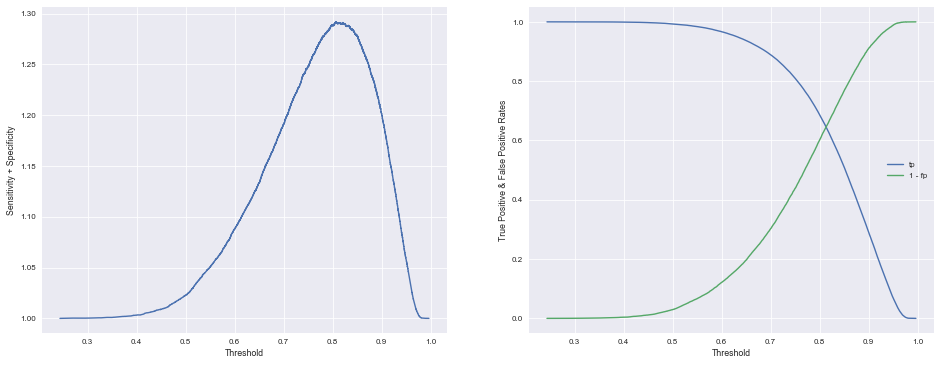

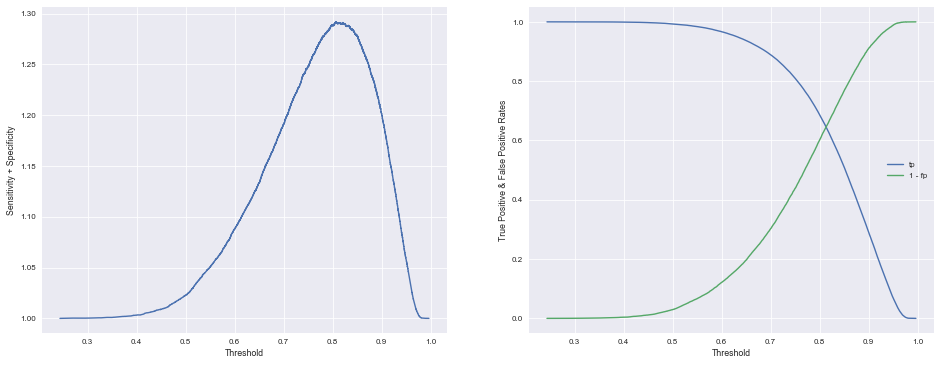

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].plot(threshold, tp + (1 - fp))
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Sensitivity + Specificity')

ax[1].plot(threshold, tp, label="tp")
ax[1].plot(threshold, 1 - fp, label="1 - fp")
ax[1].legend()
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('True Positive & False Positive Rates')
plt.show()

In [34]:
function = tp + (1 - fp)
index = np.argmax(function)

optimal_threshold = threshold[np.argmax(function)]
print('optimal threshold:', optimal_threshold)

('optimal threshold:', 0.8064728735053841)


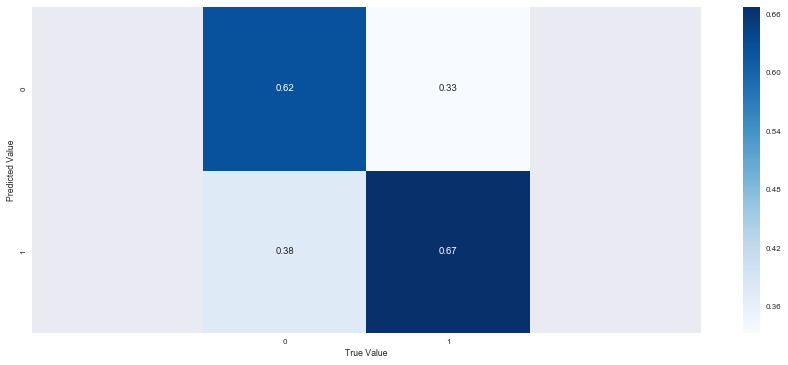

In [36]:
predict = model.predict_proba(Xte)[:,1]
predict = np.where(predict >= optimal_threshold, 1, 0)

fig, axes = plt.subplots(figsize=(15,6))

cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
ax.axis('equal')
plt.show()

In [37]:
y_default = traindata[traindata['loan_status'] == 0]
n_paid = traindata[traindata['loan_status'] == 1].sample(n=len(y_default), random_state=17) ##chosing equal amount of 1's

##creating a new dataframe for balanced set
data = y_default.append(n_paid) 

##creating the independent and dependent array
Xbal = data.drop('loan_status', axis=1)
ybal = data['loan_status']

In [38]:
## scaling it again
numerical = Xbal.columns[(Xbal.dtypes == 'float64') | (Xbal.dtypes == 'int64')].tolist()
Xbal[numerical] = sc.fit_transform(Xbal[numerical])

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = {'LDA': LinearDiscriminantAnalysis(),
          'MNB': MultinomialNB(),
          'RF': RandomForestClassifier(n_estimators=100),
          'LR': LogisticRegression(C=1)}

balset = {}
for i in models.keys():
    scores = cross_val_score(models[i], Xbal - np.min(Xbal) + 1,
                                    ybal, scoring='roc_auc', cv=3)
    balset[i] = scores
    print(i, scores, np.mean(scores))

('LDA', array([ 0.69547604,  0.70188829,  0.69662987]), 0.69799806770065398)
('RF', array([ 0.67352388,  0.67400981,  0.66930553]), 0.67227973890088888)
('LR', array([ 0.69551052,  0.7018786 ,  0.6966958 ]), 0.69802830690433337)
('MNB', array([ 0.6877427 ,  0.69228301,  0.68908949]), 0.6897050654731588)


In [40]:
model = RandomForestClassifier(n_estimators=100)
model.fit(Xbal, ybal)
predict = model.predict(Xte)

In [41]:
predict = model.predict(Xte)
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.axis('equal')

(0.0, 2.0, 0.0, 2.0)

In [ ]:
params = {'n_estimators': [50, 100, 200, 400, 600, 800]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params,
                                   scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(Xbal, ybal)
print(grid_search.best_params_)
print(grid_search.best_score_)

In [ ]:
grid_search.best_estimator_.fit(Xbal, ybal)
predict = model.predict(Xte)

In [ ]:
fig, axes = plt.subplots(figsize=(15,9))
cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.axis('equal')

In [ ]:
r = pd.DataFrame(columns=['Feature','Importance'])
ncomp = 15
r['Feature'] = feat_labels = Xbal.columns
r['Importance'] = model.feature_importances_
r.set_index(r['Feature'], inplace=True)
ax = r.sort_values('Importance', ascending=False)[:ncomp].plot.bar(width=0.9, legend=False, figsize=(15,8))
ax.set_ylabel('Relative Importance')